In [1]:
# -- ANN LAB PROJECT -- AMMAR KHALIID (016), HANZALA PAREKH (027), HARIS AAMIR (034) -- DIALOGUE GENERATIION

In [2]:
# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

2024-06-14 20:49:15.419441: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Preparinig Dataset

In [5]:
data = [
    ("Hi there!", ["Hello! How can I help you?", "Hi! What can I do for you?"]),
    ("What's your name?", ["I am a chatbot.", "You can call me Chatbot."]),
    ("How's the weather?", ["It's sunny and warm.", "Looks like it's going to rain."]),
    ("Tell me a joke.", ["Why don't scientists trust atoms? Because they make up everything!", "Why did the scarecrow win an award? Because he was outstanding in his field!"]),
    ("Goodbye", ["Goodbye! Have a nice day!", "See you later!"]),
    ("What do you do?", ["I chat with people.", "I help people with their queries."]),
    ("How old are you?", ["I am ageless.", "I don't have an age."]),
    ("Can you help me?", ["Of course! What do you need help with?", "Sure! What can I do for you?"]),
    ("What's your favorite color?", ["I like all colors.", "I don't have a favorite color."]),
    ("Do you have hobbies?", ["I like chatting with people.", "I enjoy learning new things."]),
]

inputs = []
responses = []
for input_text, response_list in data:
    for response in response_list:
        inputs.append(input_text)
        responses.append(response)

df = pd.DataFrame({'input': inputs, 'response': responses})

response_texts = ['\t' + text + '\n' for text in df['response'].tolist()]

In [6]:
# Start Tokenizer

In [7]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(df['input'].tolist() + response_texts)

input_sequences = tokenizer.texts_to_sequences(df['input'].tolist())
response_sequences = tokenizer.texts_to_sequences(response_texts)

max_encoder_seq_length = max([len(seq) for seq in input_sequences])
max_decoder_seq_length = max([len(seq) for seq in response_sequences])
vocab_size = len(tokenizer.word_index) + 1

input_sequences = pad_sequences(input_sequences, maxlen=max_encoder_seq_length, padding='post')
response_sequences = pad_sequences(response_sequences, maxlen=max_decoder_seq_length, padding='post')

encoder_input_data = np.array(input_sequences)
decoder_input_data = np.array(response_sequences)

# Create one-hot encoded decoder target data
decoder_target_data = np.zeros((len(response_texts), max_decoder_seq_length, vocab_size), dtype='float32')
for i, seq in enumerate(response_sequences):
    for t, word in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t-1, word] = 1.0


In [8]:
# Model Architecture
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.3, recurrent_dropout=0.3)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size, latent_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 64
epochs = 100

# Learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[reduce_lr])

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Function to decode sequence
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index.get('\t', 0)  # Use .get to avoid KeyError

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        if (sampled_word == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            states_value = [h, c]

    return decoded_sentence.strip()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │     24,576 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │     24,576 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    525,312 │ embedding[0][0],  │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 96)  │     24,672 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,124,448 (4.29 MB)

 Trainable params: 1,124,448 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0045 - loss: 4.5169 - val_accuracy: 0.1429 - val_loss: 4.5590 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1964 - loss: 4.5029 - val_accuracy: 0.7143 - val_loss: 4.5535 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5848 - loss: 4.4885 - val_accuracy: 0.7143 - val_loss: 4.5474 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6116 - loss: 4.4727 - val_accuracy: 0.7143 - val_loss: 4.5401 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6562 - loss: 4.4542 - val_accuracy: 0.7143 - val_loss: 4.5310 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6562 - loss: 4.4350 - val_accuracy: 0.7143 - val_loss: 4.5194 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6473 - loss: 4.4104 - val_accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6518 - loss: 3.4197 - val_accuracy: 0.7143 - val_loss: 4.2948 - learning_rate: 1.0000e-04
Epoch 45/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6518 - loss: 3.4049 - val_accuracy: 0.7143 - val_loss: 4.3009 - learning_rate: 1.0000e-04
Epoch 46/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6473 - loss: 3.4172 - val_accuracy: 0.7143 - val_loss: 4.3074 - learning_rate: 1.0000e-04
Epoch 47/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6473 - loss: 3.3985 - val_accuracy: 0.7143 - val_loss: 4.3136 - learning_rate: 1.0000e-04
Epoch 48/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6473 - loss: 3.4143 - val_accuracy: 0.7143 - val_loss: 4.3200 - learning_rate: 1.0000e-04
Epoch 49/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6473 - loss: 3.3765 - val_accuracy: 0.7143 - val_loss: 4.3270 - learning_rate: 1.0000e-04
Epoch 50/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6473 - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6741 - loss: 3.0574 - val_accuracy: 0.7143 - val_loss: 4.7019 - learning_rate: 1.0000e-04
Epoch 88/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6696 - loss: 3.0240 - val_accuracy: 0.7143 - val_loss: 4.7125 - learning_rate: 1.0000e-04
Epoch 89/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6696 - loss: 3.0460 - val_accuracy: 0.7143 - val_loss: 4.7223 - learning_rate: 1.0000e-04
Epoch 90/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6696 - loss: 2.9954 - val_accuracy: 0.7143 - val_loss: 4.7321 - learning_rate: 1.0000e-04
Epoch 91/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6696 - loss: 3.0089 - val_accuracy: 0.7143 - val_loss: 4.7417 - learning_rate: 1.0000e-04
Epoch 92/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6696 - loss: 3.0076 - val_accuracy: 0.7143 - val_loss: 4.7518 - learning_rate: 1.0000e-04
Epoch 93/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6741 - loss

In [9]:
# TRAINING AND TESTINIG ACCURACY AND LOSS

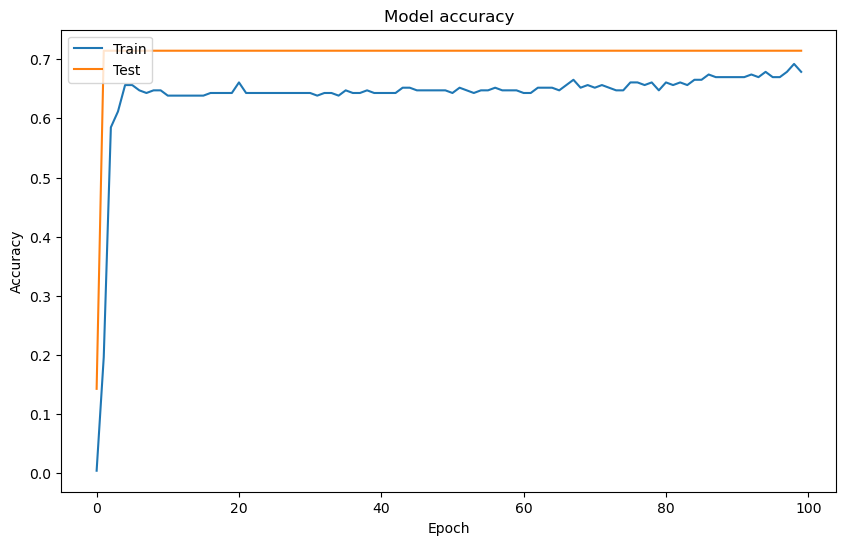

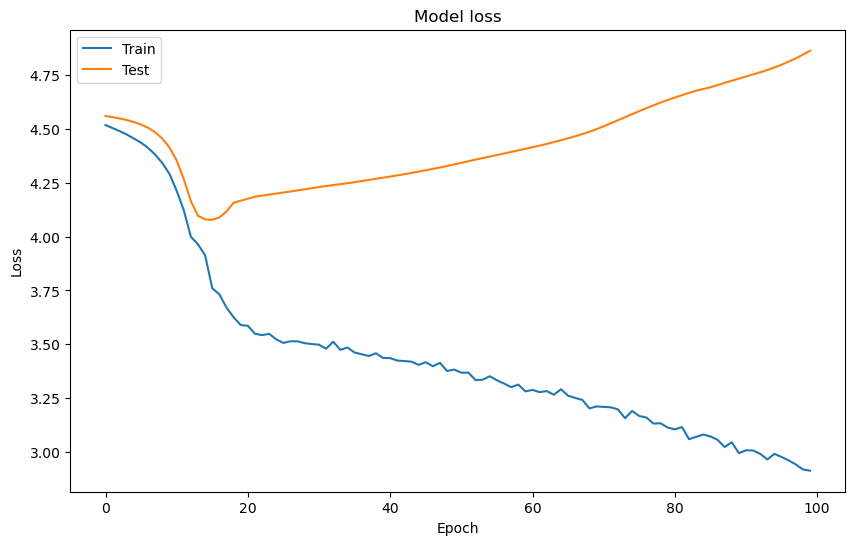

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import tkinter as tk
from tkinter import ttk

class GUI:
    def __init__(self, master):
        self.master = master
        master.title("Chatbot")

        # Set window background color
        master.configure(bg='#f0f0f0')

        # Style the chat log
        self.chat_log = tk.Text(master, bd=1, bg="#F0A596", fg="#003300", font=("Helvetica", 12), width=50, height=20, padx=10, pady=10)
        self.chat_log.config(state=tk.DISABLED)
        self.chat_log.grid(row=0, column=0, columnspan=2, padx=10, pady=10)

        # Style the entry box
        self.entry_box = tk.Entry(master, bd=1, bg="#CE7E6D", fg="#003300", font=("Helvetica", 12), width=50, insertbackground="#003300")
        self.entry_box.grid(row=1, column=0, padx=10, pady=10)

        # Style the send button
        self.send_button = tk.Button(master, text="Send", command=self.on_send_button_click, bd=1, bg="#66ff66", fg="#003300", activebackground="#99ff99", activeforeground="#003300", font=("Arial", 12, "bold"))
        self.send_button.grid(row=1, column=1, padx=10, pady=10)

        # Adding a title label
      #  self.title_label = tk.Label(master, text="", bg='#f0f0f0', fg="#003300", font=("Arial", 16, "bold"))
       # self.title_label.grid(row=0, column=0, columnspan=2, pady=(10, 0))

    def on_send_button_click(self):
        user_input = self.entry_box.get().strip()
        if user_input:
            self.entry_box.delete(0, tk.END)
            self.chat_log.config(state=tk.NORMAL)
            self.chat_log.insert(tk.END, "You: " + user_input + "\n", "user")
            self.chat_log.config(state=tk.DISABLED)
            self.get_bot_response(user_input)

    def get_bot_response(self, user_input):
        input_seq = tokenizer.texts_to_sequences([user_input])
        input_seq = pad_sequences(input_seq, maxlen=max_encoder_seq_length, padding='post')
        response = decode_sequence(input_seq)
        self.chat_log.config(state=tk.NORMAL)
        self.chat_log.insert(tk.END, "Bot: " + response + "\n", "bot")
        self.chat_log.config(state=tk.DISABLED)

# Initialize main window
root = tk.Tk()
root.geometry("500x600")

# Create an instance of the ChatbotGUI
app = GUI(root)

# Start the main loop
root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
